In [31]:
import pandas as pd
import json

df = pd.read_csv("../training_data.csv")  # 包含 text 和 label 字段

requests = []
for i, row in df.iterrows():
    question = row["text"]
    label = row["label"]

    request = {
        "custom_id": f"augment-{i}",
        "method": "POST",
        "url": "/v4/chat/completions",
        "body": {
            "model": "glm-4-flash",
            "messages": [
                {
                    "role": "system",
                    "content": "你是一个翻译专家，用于将中文翻译为英文，并返回结构化JSON格式的结果。"
                },
                {
                    "role": "user",
                    "content": f"""请将以下原始问句翻译为英文，并返回如下 JSON 格式：
{{"text": "<英文翻译>", "label": {label} }}

注意：
- 仅返回 JSON。
- 不要添加任何多余解释或标点。
- 保持标签 label 不变。

原始问句：\"{question}\""""
                }
            ],
            "temperature": 0.1
        }
    }
    requests.append(request)

# 写入 JSONL 文件
with open("chinese2english_augmented.jsonl", "w", encoding="utf-8") as f:
    for req in requests:
        json.dump(req, f, ensure_ascii=False)
        f.write("\n")

print("✅ 批量数据写入完成：chinese2english_augmented.jsonl")


✅ 批量数据写入完成：chinese2english_augmented.jsonl


In [ ]:
from zhipuai import ZhipuAI
 
client = ZhipuAI(api_key="") # 请填写您自己的APIKey
  
result = client.files.create(
    file=open("./chinese2english_augmented.jsonl", "rb"),
    purpose="batch"
)
print(result.id)

1744770491_e8d520346be249bb8dbcf15fe6b5a574


In [ ]:
from zhipuai import ZhipuAI
 

create = client.batches.create(
    input_file_id="1744770491_e8d520346be249bb8dbcf15fe6b5a574",
    endpoint="/v4/chat/completions", 
    auto_delete_input_file=True,
    metadata={
        "description": "chinese2english"
    }
)
print(create)
  

Batch(id='batch_1912332233734361088', completion_window=None, created_at=1744770508594, endpoint='/v4/chat/completions', input_file_id='1744770491_e8d520346be249bb8dbcf15fe6b5a574', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=None, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'chinese2english'}, output_file_id=None, request_counts=BatchRequestCounts(completed=None, failed=None, total=2865))


In [ ]:
batch_job = client.batches.retrieve("1744770491_e8d520346be249bb8dbcf15fe6b5a574")
print(batch_job)

Batch(id=None, completion_window=None, created_at=None, endpoint=None, input_file_id=None, object=None, status=None, cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=None, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=None)


## 处理响应

In [37]:
import json
import csv
import re

# 输入和输出路径
input_path = "chinese2english_result.jsonl"     # 替换为实际响应文件路径
output_path = "translated_dataset.csv"

# 存储结果
results = []

# 提取并解析翻译内容
def extract_text_label(content):
    # 清除 ```json 包裹（如存在）
    content = content.strip()
    if content.startswith("```json"):
        content = re.sub(r"^```json\s*", "", content)
        content = re.sub(r"\s*```$", "", content)

    # 转换为 JSON 并返回 text 和 label
    try:
        data = json.loads(content)
        return data["text"], data["label"]
    except Exception as e:
        print(f"❌ 无法解析内容：{content}，错误：{e}")
        return None, None

# 读取 JSONL
with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line)
            content_str = data["response"]["body"]["choices"][0]["message"]["content"]
            text, label = extract_text_label(content_str)
            if text is not None and label is not None:
                results.append({"text": text, "label": label})
        except Exception as e:
            print(f"❌ 行解析失败：{e}，行内容：{line[:100]}...")

# 写入 CSV
with open(output_path, "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["text", "label"])
    writer.writeheader()
    writer.writerows(results)

print(f"✅ 成功写入 CSV：{output_path}，共 {len(results)} 条")


✅ 成功写入 CSV：translated_dataset.csv，共 2865 条


In [38]:
import pandas as pd

# 读取中文原始数据
df_cn = pd.read_csv("./training_data.csv")  # 原始中文数据集，含 text 和 label

# 读取翻译后的英文数据
df_en = pd.read_csv("./translated_dataset.csv")  # 已翻译的英文数据，格式 text,label

# 合并数据
df_all = pd.concat([df_cn, df_en], ignore_index=True)

# 保存为新文件
df_all.to_csv("combined_training_data.csv", index=False, encoding="utf-8")

print(f"✅ 合并完成，共 {len(df_all)} 条数据，已保存至 combined_training_data.csv")


✅ 合并完成，共 5730 条数据，已保存至 combined_training_data.csv


## DataSet distribution

📊 标签分布统计：
标签 0：1894 条，占比 33.05%
标签 1：1808 条，占比 31.55%
标签 2：2028 条，占比 35.39%


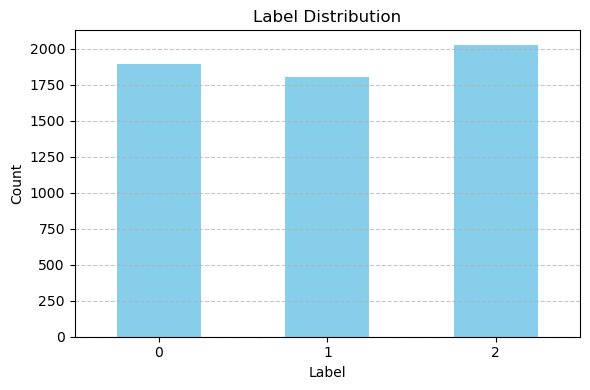

In [40]:
import pandas as pd

# 加载合并后的数据集
df = pd.read_csv("combined_training_data.csv")

# 统计 label 分布
label_counts = df["label"].value_counts().sort_index()
label_percent = df["label"].value_counts(normalize=True).sort_index() * 100

# 打印结果
print("📊 标签分布统计：")
for label in label_counts.index:
    print(f"标签 {label}：{label_counts[label]} 条，占比 {label_percent[label]:.2f}%")

# 如果需要，也可以可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
label_counts.plot(kind="bar", color="skyblue")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
